# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1320s3vd1"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.optimizer_v2 import adadelta as adadelta_v2
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

2021-11-21 17:10:03.277236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-21 17:10:03.277307: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_vd_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(707, 32, 20, 3)
(707, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

2021-11-21 17:10:07.838468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-21 17:10:07.838529: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-21 17:10:07.838563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b99cd54f86b6): /proc/driver/nvidia/version does not exist
2021-11-21 17:10:07.839062: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/100
177/177 [==============================] - 2s 10ms/step - loss: 1.7979 - accuracy: 0.4229 - val_loss: 1.1062 - val_accuracy: 0.7324
Epoch 2/100
177/177 [==============================] - 1s 7ms/step - loss: 0.7881 - accuracy: 0.7496 - val_loss: 0.5533 - val_accuracy: 0.8380
Epoch 3/100
177/177 [==============================] - 2s 9ms/step - loss: 0.4058 - accuracy: 0.8755 - val_loss: 0.4031 - val_accuracy: 0.8944
Epoch 4/100
177/177 [==============================] - 1s 8ms/step - loss: 0.2503 - accuracy: 0.9264 - val_loss: 0.2056 - val_accuracy: 0.9296
Epoch 5/100
177/177 [==============================] - 1s 8ms/step - loss: 0.1971 - accuracy: 0.9321 - val_loss: 0.1520 - val_accuracy: 0.9648
Epoch 6/100
177/177 [==============================] - 1s 7ms/step - loss: 0.1520 - accuracy: 0.9463 - val_loss: 0.1140 - val_accuracy: 0.9577
Epoch 7/100
177/177 [==============================] - 1s 7ms/step - loss: 0.0842 - accuracy: 0.9731 - val_loss: 0.0854 - val_accuracy: 0.957

### Learing result
 
* Visualization of the training and validation results

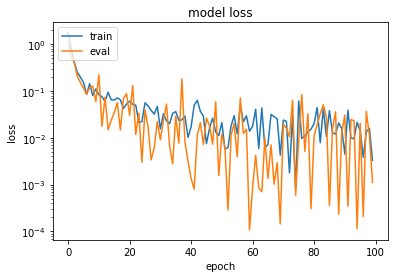

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


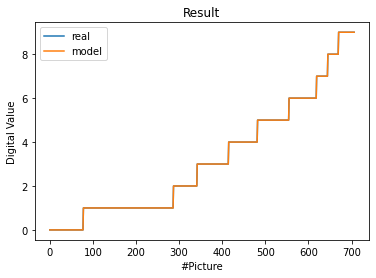

In [6]:
Input_dir='ziffer_sortiert_vd_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

2021-11-21 17:12:59.806248: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpsd1lzzfs/assets


2021-11-21 17:13:01.120966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-11-21 17:13:01.121031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-11-21 17:13:01.121765: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpsd1lzzfs
2021-11-21 17:13:01.124239: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-11-21 17:13:01.124267: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpsd1lzzfs
2021-11-21 17:13:01.134325: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-11-21 17:13:01.198139: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpsd1lzzfs
2021-11-21 17:13:01.217617: I tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 95856 

219168

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: /tmp/tmpmrga_vl8/assets


INFO:tensorflow:Assets written to: /tmp/tmpmrga_vl8/assets
2021-11-21 17:13:03.100202: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-11-21 17:13:03.100269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-11-21 17:13:03.100510: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpmrga_vl8
2021-11-21 17:13:03.103862: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-11-21 17:13:03.103906: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpmrga_vl8
2021-11-21 17:13:03.115242: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-11-21 17:13:03.186468: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpmrga_vl8
2021-11-21 17:13:03.207960: I tensorflow/cc/saved_model/loader.cc:283] SavedMode

dig1320s3vd1q.tflite


62136

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.

ziffer_vd_resize/0_dig10_20211106-164057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-165057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-171557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-172057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-172557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-173557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-174557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-175057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-175557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-180057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-180557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-181557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-182057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-183057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-184057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-184557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-185057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-185557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-190557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-194557.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-210057.jpg 0 6


ziffer_vd_resize/0_dig10_20211106-231556.jpg 0 6


ziffer_vd_resize/10_dig0001_20211110-223219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-223719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-224219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-224719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-225219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-225719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-230219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-230719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-231219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-231719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-232219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-232719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-233219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-233719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-234219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-234719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-235219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211110-235719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-000219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-000719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-001219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-001719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-002219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-002719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-003219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-003719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-004219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-004719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-005219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-005719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-010219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-010719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-011219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-011719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-012219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-012719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-013219.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-013719.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-070826.jpg 1 5


ziffer_vd_resize/10_dig0001_20211111-084801.jpg 1 9


ziffer_vd_resize/10_dig0001_20211111-105825.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-110825.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-111325.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-111825.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-112325.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-112825.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-113325.jpg 1 0


ziffer_vd_resize/10_dig0001_20211111-133825.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-134325.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-134825.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-135325.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-135825.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-135932.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-140432.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-140932.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-141432.jpg 1 7


ziffer_vd_resize/10_dig0001_20211111-202018.jpg 1 8


ziffer_vd_resize/10_dig0001_20211112-000017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-001517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-002017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-003017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-003517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-004017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-004517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-005017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-010017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-010517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-011017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-012017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-012517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-013017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-013517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-014017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-015017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-015517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-020017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-020517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-021017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-021517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-022017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-022517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-023017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-023517.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-024017.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-081114.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-081614.jpg 1 9


ziffer_vd_resize/10_dig0001_20211112-085614.jpg 1 3


ziffer_vd_resize/10_dig0001_20211112-090114.jpg 1 3


ziffer_vd_resize/10_dig0001_20211112-090614.jpg 1 3


ziffer_vd_resize/10_dig0001_20211112-091114.jpg 1 3


ziffer_vd_resize/10_dig001_20211107-064141.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-064641.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-065141.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-065641.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-070141.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-070641.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-071141.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-071641.jpg 1 7


ziffer_vd_resize/10_dig001_20211107-072141.jpg 1 7


ziffer_vd_resize/10_dig001_20211108-081553.jpg 1 2


ziffer_vd_resize/10_dig001_20211108-082053.jpg 1 2


ziffer_vd_resize/10_dig001_20211108-082553.jpg 1 2


ziffer_vd_resize/10_dig001_20211108-083053.jpg 1 2


ziffer_vd_resize/10_dig001_20211111-063826.jpg 1 5


ziffer_vd_resize/10_dig01_20211111-141932.jpg 1 3


ziffer_vd_resize/10_dig01_20211111-142432.jpg 1 3


ziffer_vd_resize/10_dig01_20211111-143432.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-115850.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-120350.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-120850.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-121350.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-121850.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-122351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-122851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-123351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-123851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-124351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-124851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-125351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-125851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-134851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-135351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-140351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-140851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-141351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-141851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-142351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-142851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-143351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-143851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-144351.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-144851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-145851.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-150352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-150852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-151352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-151852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-152352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-152852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-153352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-153852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-154352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-154852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-155352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-155852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-160352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-161352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-161852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-162352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-162852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-163852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-164352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-164852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-165352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-165852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-170352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-170852.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-171352.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-171853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-172353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-172853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-173353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-173853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-174353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-174853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-175353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-175853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-180353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-180853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-181353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-181853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-182353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-182853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-183353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-183853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-184353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-184853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-185353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-185853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-190353.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-190853.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-191354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-191854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-192354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-192854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-193354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-193854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-194354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-194854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-195354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-195854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-200354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-200854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-201354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-201854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-202354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-202854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-203354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-203854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-204354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-204854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-205354.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-205854.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-210355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-211355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-211855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-212355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-212855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-213355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-213855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-214355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-214855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-215355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-220355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-220855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-221355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-221855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-222355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-222855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-223355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-223855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-224355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-224855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-225355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-225855.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-230355.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-230856.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-231356.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-231856.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-232356.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-232856.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-233356.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-233856.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-234356.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-234856.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-235356.jpg 1 3


ziffer_vd_resize/10_dig1_20211109-235856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-000356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-000856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-001356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-001856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-002356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-002856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-003356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-003856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-004356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-004856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-005856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-010356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-010856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-011356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-011856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-012356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-012856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-013356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-013856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-014356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-014856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-015356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-015856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-020356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-020856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-021356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-021856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-022356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-022856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-023357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-023857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-024356.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-024856.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-025357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-025857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-030357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-030857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-031357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-031857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-032357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-032857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-033357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-033857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-034357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-034857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-035357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-035857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-040357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-040857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-041357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-041857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-042357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-042857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-043357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-043857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-044357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-044857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-045357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-045857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-050357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-050857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-051357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-051857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-052357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-052857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-053357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-053857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-054357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-054857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-055357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-055857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-060357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-060857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-061357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-061857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-062357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-062857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-063357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-063857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-064357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-064857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-065357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-065857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-070357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-070857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-071357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-071857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-072357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-072857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-073357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-073857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-074357.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-074857.jpg 1 3


ziffer_vd_resize/10_dig1_20211110-075357.jpg 1 3


ziffer_vd_resize/2_dig0001_20211111-065300.jpg 2 7


ziffer_vd_resize/2_dig0001_20211111-230017.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-231017.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-231517.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-233017.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-233517.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-234017.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-234517.jpg 2 9


ziffer_vd_resize/2_dig0001_20211111-235017.jpg 2 9


ziffer_vd_resize/2_dig0001_20211112-000517.jpg 2 9


ziffer_vd_resize/2_dig0001_20211112-011517.jpg 2 9


ziffer_vd_resize/2_dig0001_20211112-014517.jpg 2 9


ziffer_vd_resize/2_dig001_20211111-093301.jpg 2 9


ziffer_vd_resize/3_dig001_20211111-033219.jpg 3 2


ziffer_vd_resize/3_dig001_20211111-034219.jpg 3 2


ziffer_vd_resize/3_dig001_20211111-041719.jpg 3 2


ziffer_vd_resize/3_dig001_20211111-055218.jpg 3 1


ziffer_vd_resize/3_dig001_20211111-055718.jpg 3 1


ziffer_vd_resize/3_dig001_20211111-060218.jpg 3 1


ziffer_vd_resize/3_dig01_20211110-220748.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-220911.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-221630.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-222219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-222719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-223219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-223719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-224219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-224719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-225219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-225719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-230219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-230719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-231219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-231719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-232219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-232719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-233219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-233719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-234219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-234719.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-235219.jpg 3 2


ziffer_vd_resize/3_dig01_20211110-235719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-000219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-001719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-002219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-002719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-003219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-003719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-004219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-004719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-005219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-005719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-010219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-011719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-012219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-013219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-013719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-014219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-014719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-015219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-020219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-020719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-021219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-021719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-022219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-022719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-023219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-023719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-024219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-024719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-025219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-025719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-030219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-030719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-031219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-031719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-032219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-032719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-033219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-033719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-034219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-034719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-035219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-035719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-040219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-040719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-041219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-041719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-042219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-042719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-043219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-043719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-044219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-044719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-045219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-045719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-050219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-050719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-051219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-051719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-052218.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-052718.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-053218.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-053718.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-054218.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-054718.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-055218.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-055718.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-060218.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-060718.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-061218.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-061718.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-062219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-062719.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-063219.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-063326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-064326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-064826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-065326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-065826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-070326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-070826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-071326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-071826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-072326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-072826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-073326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-073826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-074326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-075326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-075826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-080326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-080826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-081326.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-081826.jpg 3 2


ziffer_vd_resize/3_dig01_20211111-082326.jpg 3 2


ziffer_vd_resize/4_dig001_20211111-035219.jpg 4 2


ziffer_vd_resize/4_dig001_20211111-071300.jpg 4 1


ziffer_vd_resize/4_dig001_20211111-121348.jpg 4 1


ziffer_vd_resize/4_dig001_20211111-122348.jpg 4 1


ziffer_vd_resize/4_dig001_20211111-142432.jpg 4 9


ziffer_vd_resize/4_dig001_20211111-143432.jpg 4 9


ziffer_vd_resize/4_dig001_20211111-143932.jpg 4 9


ziffer_vd_resize/4_dig01_20211107-092056.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-093056.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-104055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-105555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-114555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-120055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-121055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-124055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-124555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-125055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-125555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-130555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-131055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-132055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-143055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-153555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-154054.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-161055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-162055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-164055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-165555.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-182055.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-211554.jpg 4 6


ziffer_vd_resize/4_dig01_20211107-212054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-001054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-004054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-014054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-015554.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-021554.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-022554.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-033554.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-035054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-040554.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-041054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-051054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-052054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-054054.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-054554.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-062553.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-063553.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-064053.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-064553.jpg 4 6


ziffer_vd_resize/4_dig01_20211108-065053.jpg 4 6


ziffer_vd_resize/6_dig0001_20211110-220558.jpg 6 1


ziffer_vd_resize/6_dig0001_20211110-224758.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-225258.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-230258.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-230758.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-231258.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-231758.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-232258.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-232759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-233259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-233759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-234259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-234759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-235259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211110-235759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-000259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-000759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-001259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-001759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-002259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-002759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-003259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-003759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-004259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-004759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-005259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-005759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-010259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-010759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-011259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-011759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-012259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-012759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-013259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-013759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-014259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-014759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-015259.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-015759.jpg 6 8


ziffer_vd_resize/6_dig0001_20211111-122348.jpg 6 8


ziffer_vd_resize/6_dig001_20211106-103130.jpg 6 1


ziffer_vd_resize/6_dig001_20211106-103630.jpg 6 1


ziffer_vd_resize/6_dig001_20211106-104130.jpg 6 1


ziffer_vd_resize/6_dig001_20211106-104630.jpg 6 1


ziffer_vd_resize/6_dig001_20211106-105130.jpg 6 1


ziffer_vd_resize/6_dig001_20211112-151801.jpg 6 5


ziffer_vd_resize/6_dig001_20211112-152301.jpg 6 5


ziffer_vd_resize/6_dig01_20211106-165138.jpg 6 3


ziffer_vd_resize/6_dig01_20211106-165638.jpg 6 3


ziffer_vd_resize/6_dig01_20211106-170138.jpg 6 3


ziffer_vd_resize/6_dig01_20211109-033348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-034348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-035348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-040848.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-041348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-041848.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-042348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-043348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-045348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-050348.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-050848.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-051349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-052349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-052849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-053349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-053849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-060349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-062849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-063349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-064349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-065349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-070349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-074349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-075849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-080849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-081349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-081849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-083349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-083849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-084349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-084849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-085349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-085849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-090349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-090849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-091349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-091849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-092349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-092849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-093349.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-093849.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-094350.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-094850.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-095850.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-100350.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-100850.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-101350.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-101850.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-102350.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-102850.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-103350.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-103850.jpg 6 8


ziffer_vd_resize/6_dig01_20211109-104350.jpg 6 8


ziffer_vd_resize/6_dig01_20211111-083326.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-083826.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-084826.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-085326.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-090826.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-091326.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-091826.jpg 6 3


ziffer_vd_resize/6_dig01_20211111-092326.jpg 6 3


ziffer_vd_resize/6_dig100_20211111-154432.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-155932.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-160432.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-174132.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-211017.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-224517.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-234017.jpg 6 0


ziffer_vd_resize/6_dig100_20211111-235517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-002517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-003517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-004517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-005017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-010017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-014017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-014517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-020017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-020517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-023517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-025017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-025517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-031517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-032517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-033517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-040017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-043517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-045517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-050017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-052017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-053517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-054017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-054517.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-060017.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-063016.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-072614.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-083614.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-084614.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-090114.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-092114.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-093614.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-103114.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-110113.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-114613.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-121705.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-123205.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-130705.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-142801.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-144301.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-150301.jpg 6 0


ziffer_vd_resize/6_dig100_20211112-151801.jpg 6 0


ziffer_vd_resize/6_dig10_20211110-220558.jpg 6 1


ziffer_vd_resize/6_dig1_20211107-183741.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-184241.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-184741.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-190741.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-201742.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-202242.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-202742.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-203242.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-204742.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-205242.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-224243.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-232743.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-233744.jpg 6 3


ziffer_vd_resize/6_dig1_20211107-235744.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-002744.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-005744.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-010744.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-013744.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-020244.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-021744.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-022244.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-024244.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-030244.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-033245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-034745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-035745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-041745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-042245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-044245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-044745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-045245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-050745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-051745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-053745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-055245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-062245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-064245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-064745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-065745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-070245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-070745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-071745.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-072245.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-073246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-074246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-074746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-075246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-075746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-085246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-090246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-091246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-091746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-092246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-094246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-100246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-100746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-101246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-101746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-102246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-102746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-103246.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-103746.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-104340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-104840.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-105340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-110340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-111340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-111840.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-112340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-112840.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-113340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-113840.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-114340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-114840.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-115340.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-115840.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-120341.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-120841.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-121341.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-121841.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-122341.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-122841.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-123341.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-123841.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-134841.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-142342.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-143342.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-145842.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-150342.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-150842.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-154342.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-155342.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-155842.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-160842.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-161843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-162343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-163843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-164343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-164843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-165343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-165843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-170843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-171343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-171843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-172343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-173343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-173843.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-174343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-175343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-180343.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-182844.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-185344.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-191344.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-192844.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-194844.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-195344.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-203345.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-204345.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-205345.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-205845.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-211845.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-213345.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-214346.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-214846.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-220346.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-221346.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-221846.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-222346.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-223346.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-223846.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-230847.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-232347.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-233847.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-234847.jpg 6 3


ziffer_vd_resize/6_dig1_20211108-235347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-000847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-001347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-002847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-003347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-003847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-004347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-004847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-005347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-005847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-010847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-011347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-011847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-012847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-013347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-013847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-014347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-014847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-015347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-020847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-021347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-022347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-022847.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-023347.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-023848.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-024348.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-024848.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-025348.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-025848.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-030848.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-031348.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-041848.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-050348.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-062349.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-063349.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-065849.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-074849.jpg 6 3


ziffer_vd_resize/6_dig1_20211109-080349.jpg 6 3


ziffer_vd_resize/8_dig0001_20211111-035759.jpg 8 3


ziffer_vd_resize/8_dig01_20211110-224258.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-001259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-003259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-020259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-020759.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-021259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-021759.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-023259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-024259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-034259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-042300.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-043259.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-043759.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-045800.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-051800.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-085826.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-090326.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-092825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-093325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-094325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-095325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-095825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-100825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-103825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-104825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-105325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-110325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-110825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-111325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-112325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-112825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-113825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-114325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-114825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-115325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-115825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-120325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-120825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-121325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-121825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-122825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-131325.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-131825.jpg 8 3


ziffer_vd_resize/8_dig01_20211111-135325.jpg 8 3


ziffer_vd_resize/8_dig100_20211110-220558.jpg 8 6


ziffer_vd_resize/9_dig0001_20211111-061800.jpg 9 1


ziffer_vd_resize/9_dig0001_20211111-104825.jpg 9 0


ziffer_vd_resize/9_dig0001_20211111-110325.jpg 9 0


ziffer_vd_resize/9_dig0001_20211111-114325.jpg 9 6


ziffer_vd_resize/9_dig0001_20211111-114825.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-115825.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-120325.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-120825.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-121325.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-132325.jpg 9 1


ziffer_vd_resize/9_dig0001_20211111-215017.jpg 9 6


ziffer_vd_resize/9_dig0001_20211111-215517.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-220017.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-220517.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-221017.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-221517.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-222017.jpg 9 6


ziffer_vd_resize/9_dig0001_20211111-222517.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-223017.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-223517.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-224017.jpg 9 8


ziffer_vd_resize/9_dig0001_20211111-224517.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-134205.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-134705.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-135205.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-135705.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-140301.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-140801.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-141801.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-142301.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-142801.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-143301.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-143801.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-144301.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-144801.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-145301.jpg 9 8


ziffer_vd_resize/9_dig0001_20211112-145801.jpg 9 8


ziffer_vd_resize/9_dig01_20211109-042848.jpg 9 8


ziffer_vd_resize/9_dig01_20211109-072349.jpg 9 8


ziffer_vd_resize/9_dig01_20211109-082349.jpg 9 8


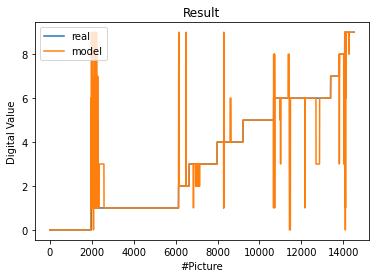

In [9]:
Input_dir='ziffer_vd_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()